In [1]:
import numpy as np
import pandas as pd

In [2]:
retail = pd.read_csv("OnlineRetail.csv")

In [3]:
features = ["CustomerID", "Quantity", "InvoiceDate"]

In [4]:
retail = retail.dropna(subset=features)

In [5]:
data = retail[features].copy()

In [6]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data["InvoiceDate"]= (data["InvoiceDate"] - pd.Timestamp("1970-01-01")) / pd.Timedelta(days=1)

In [7]:
customer_summary = data.groupby("CustomerID").agg({"Quantity":"sum", "InvoiceDate":["min", "max", "count"]})
customer_summary.columns = ['_'.join(col).strip() for col in customer_summary.columns.values]

In [8]:
customer_summary

,Quantity_sum,InvoiceDate_min,InvoiceDate_max,InvoiceDate_count
CustomerID,,,,
12346.0,0,14992.417361,14992.428472,2
12347.0,2458,14950.622917,15315.661111,182
12348.0,2341,14959.797917,15242.550694,31
12349.0,631,15299.410417,15299.410417,73
12350.0,197,15007.667361,15007.667361,17
...,...,...,...,...
18280.0,45,15040.411111,15040.411111,10
18281.0,54,15137.453472,15137.453472,7
18282.0,98,15191.565972,15310.488194,13


In [9]:
data = ((data-data.min())/(data.max()-data.min()))* 99 + 1

In [10]:
def random_centroids(data,k):
    centroids=[]
    for i in range(k):
        centroid = data.apply(lambda x : float(x.sample(n=1, random_state = i).iloc[0]))
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)

In [11]:
def get_labels(data,centroids):
    distances = centroids.apply(lambda x : np.sqrt(((data - x) ** 2).sum(axis = 1)))  
    return distances.idxmin(axis = 1)

In [12]:
def new_centroids(data,labels,k):
    return data.groupby(labels).apply(lambda x : np.exp(np.log(x).mean())).T

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [78]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components = 2)
    data_2d = pca.fit_transform(data)
    centroid_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Customer Segments via PCA + K-Means (Iter: {iteration})')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1],c=labels)
    plt.scatter(x=centroid_2d[:,0],y=centroid_2d[:,1], c='red', s=50, marker='X',)
    plt.show()

In [15]:
cs = customer_summary

In [16]:
cs = ((cs - cs.min())/(cs.max()-cs.min())) * 99 + 1

In [17]:
cs.describe()

,Quantity_sum,InvoiceDate_min,InvoiceDate_max,InvoiceDate_count
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,1.716210,40.235325,75.704441,2.141728
std,2.347993,31.408386,26.737353,2.883324
min,1.000000,1.000000,1.000000,1.000000
25%,1.229132,12.190031,62.085994,1.198447
50%,1.335658,32.942354,86.767958,1.508519
75%,1.635765,69.501192,95.717807,2.252694
max,100.000000,100.000000,100.000000,100.000000


In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def plot_elbow_curve(data, k_range=10):
    inertia = []
    k_values = list(range(1, k_range + 1))
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertia, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
    plt.title('Elbow Method For Optimal k')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

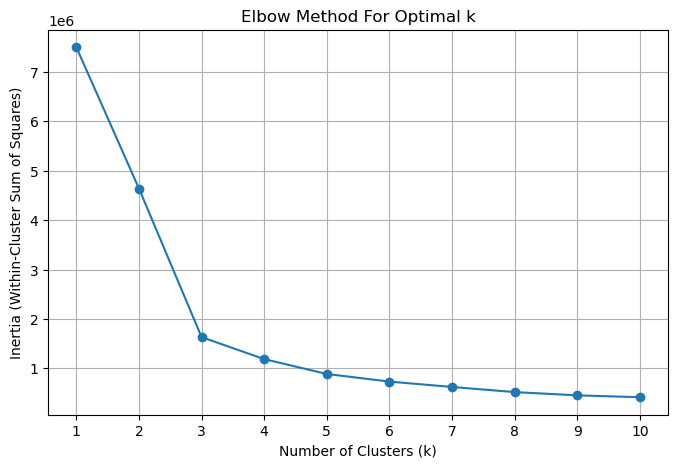

In [19]:
plot_elbow_curve(cs)

In [20]:
cs_centroids = random_centroids(cs,3)

In [21]:
cs_label = get_labels(cs, cs_centroids)

In [22]:
cs_label.value_counts()

1    2128
0    1208
2    1036
Name: count, dtype: int64

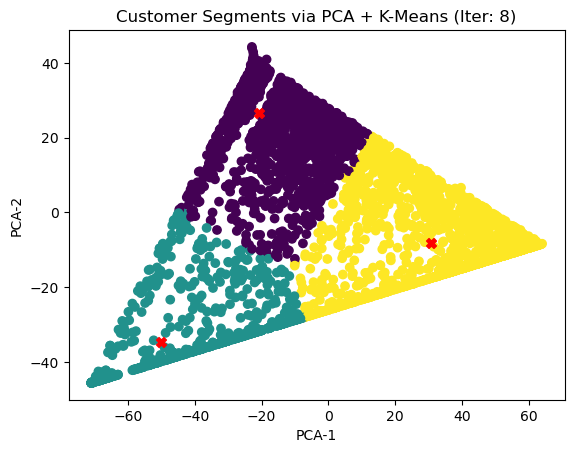

In [80]:
max_iteration = 100
k=3
cs_centroids = random_centroids(cs,k)
old_centroids = pd.DataFrame()
iteration = 1
while iteration < max_iteration and not cs_centroids.equals(old_centroids):
    old_centroids = cs_centroids

    cs_labels = get_labels(cs, cs_centroids)
    cs_centroids =  new_centroids(cs,cs_labels,k)
    plt.xlabel('PCA-1')
    plt.ylabel('PCA-2')
    plot_clusters(cs, cs_labels, cs_centroids, iteration)
    iteration += 1

In [24]:
cs_centroids

,0,1,2
Quantity_sum,1.854834,1.262336,1.365533
InvoiceDate_min,8.989647,13.896044,71.002866
InvoiceDate_max,88.575649,20.916808,83.900723
InvoiceDate_count,2.443249,1.280555,1.497564


In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(cs)
loading = pd.DataFrame(pca.components_.T, index=cs.columns, columns=['PC1', 'PC2'])
print(loading)

                        PC1       PC2
Quantity_sum      -0.004903  0.022455
InvoiceDate_min    0.869517 -0.493032
InvoiceDate_max    0.493835  0.868847
InvoiceDate_count -0.006591  0.038992
